<a href="https://colab.research.google.com/github/nhlong1512/IS403.N21/blob/main/Final/Final02052023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Để thuận tiện cho việc xây dựng mô hình ARIMA ta sẽ chuyển chuỗi giá close sang chuỗi dừng bằng cách lấy lợi suất theo công thức sai phân bậc 1 của logarit như bên dưới:


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.stattools import adfuller

Hàm data.shift(1) sẽ giúp ta lấy trễ bậc 1 của chuỗi giá close. Công thức tính toán lợi suất như sau:

In [9]:
#import file csv
data = pd.read_csv("BTC-USD.csv")
data
data['Close']

0        3843.520020
1        3943.409424
2        3836.741211
3        3857.717529
4        3845.194580
            ...     
1546    27139.888670
1547    27268.130860
1548    28348.441410
1549    28033.562500
1550    28478.484380
Name: Close, Length: 1551, dtype: float64

In [14]:
# Tính chuỗi return
r_t = np.log(data['Close']/data['Close'].shift(1))

mean = np.nanmean(r_t)
r_t[0]=mean
r_t[:5]

0    0.001292
1    0.025657
2   -0.027422
3    0.005452
4   -0.003251
Name: Close, dtype: float64

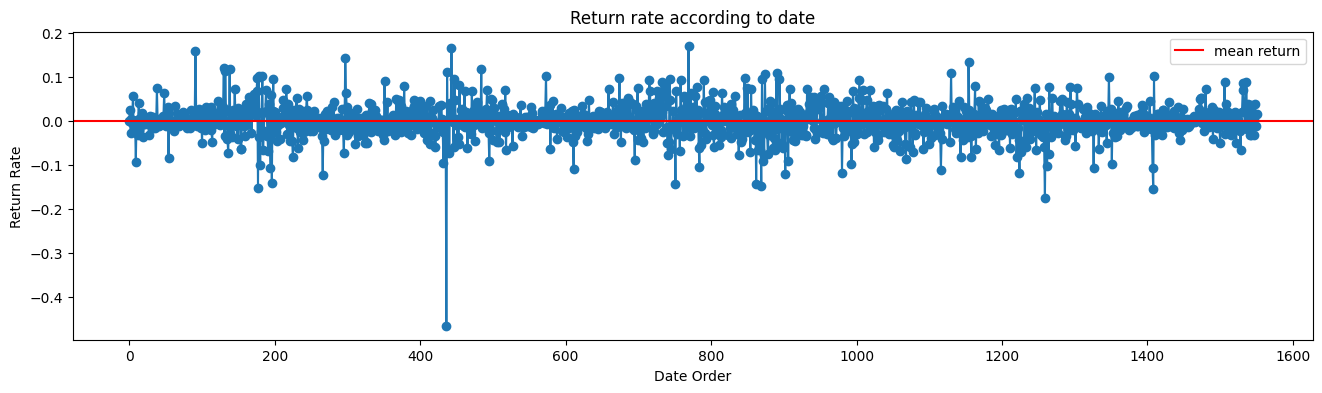

In [15]:
plt.figure(figsize=(16, 4))
plt.plot(np.arange(r_t.shape[0]), r_t, '-o')
plt.axhline(y=mean, label='mean return', c='red')
plt.title('Return rate according to date')
plt.xlabel('Date Order')
plt.ylabel('Return Rate')
plt.legend()
plt.show()

Nhận xét: Biểu đồ chuỗi lợi suất cho thấy nó là một biến động ngẫu nhiên dạng nhiễu trắng, có trung bình gần như bằng 0 và phương sai không đổi.

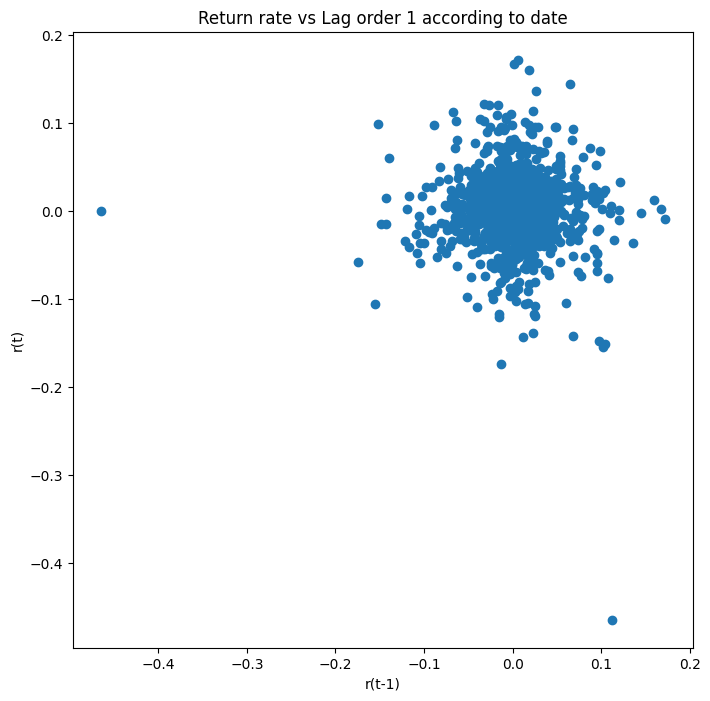

In [16]:
plt.figure(figsize=(8, 8))
plt.scatter(x=r_t[1:], y=r_t[:-1])
plt.title('Return rate vs Lag order 1 according to date')
plt.xlabel('r(t-1)')
plt.ylabel('r(t)')
plt.show()

Ta hãy cũng khảo sát qua biểu đồ phân phối xác suất của chuỗi lợi suất.

<ipython-input-17-3bed7b96cc6a>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(r_t, bins = 20)


Text(0, 0.5, 'frequency')

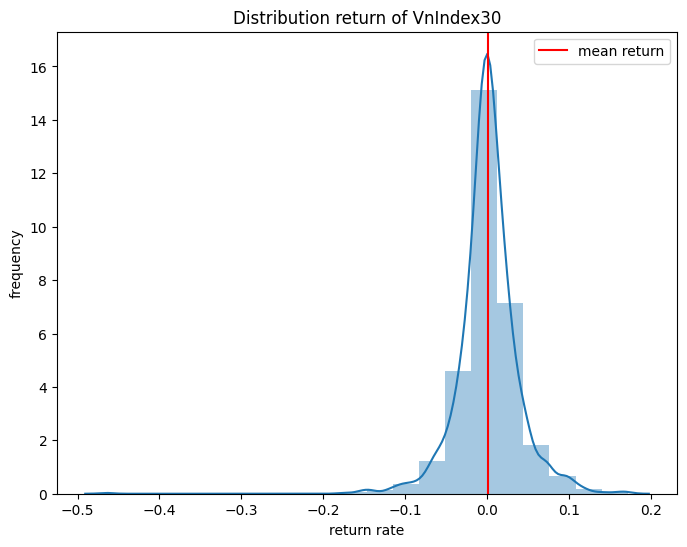

In [17]:
plt.figure(figsize = (8, 6))
sns.distplot(r_t, bins = 20)
plt.axvline(x=mean, label='mean return', c='red')
plt.title('Distribution return of VnIndex30')
plt.legend()
plt.xlabel('return rate')
plt.ylabel('frequency')

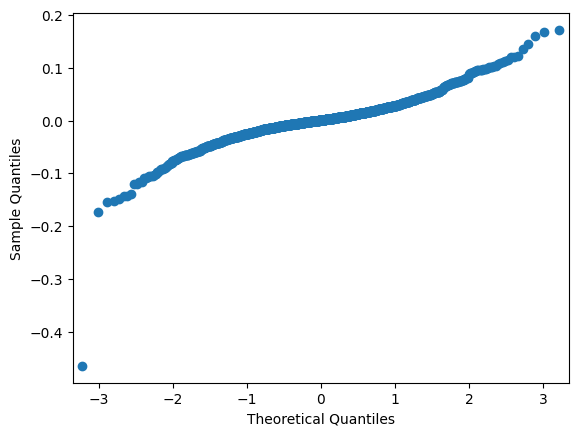

In [18]:
sm.qqplot(r_t)
plt.show()

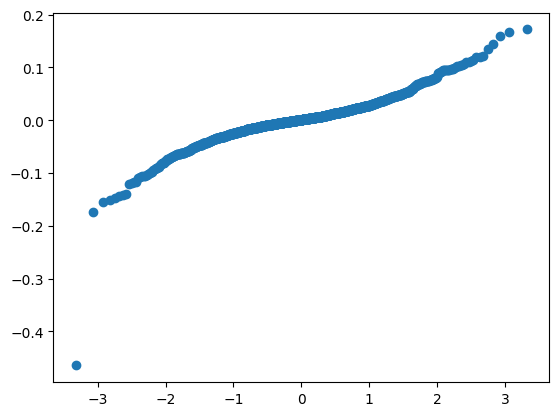

In [19]:
tq = stats.probplot(r_t)
plt.scatter(x=tq[0][0], y = tq[0][1])
plt.show()

Như vậy từ đồ thị ta có thể khẳng định chuỗi lợi suất có phân phối chuẩn vì đồ thị của phân phối lý thuyết và phân phối thực nghiệm nằm trên cùng một đường thẳng.

In [21]:
result = adfuller(r_t)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.541854
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


Gía trị p-value < 0.05, kết luận chúng ta sẽ bác bỏ giả thuyết Ho
. Phương trình đặc trưng không có nghiệm đơn vị. Do đó chuỗi lợi suất có tính chất dừng.

**Xây dựng mô hình**
<br/>
**Lựa chọn tham số ARIMA(p,d,q)**

---




<Figure size 800x600 with 0 Axes>

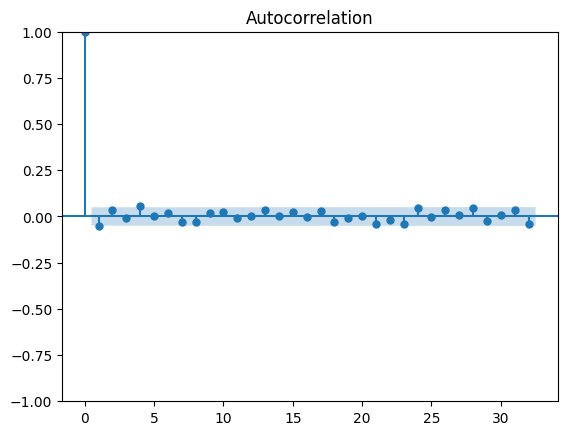

In [24]:
#Tự tương quan (ACF - AutoCorrelation Function):
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax1 = plot_acf(r_t)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 800x600 with 0 Axes>

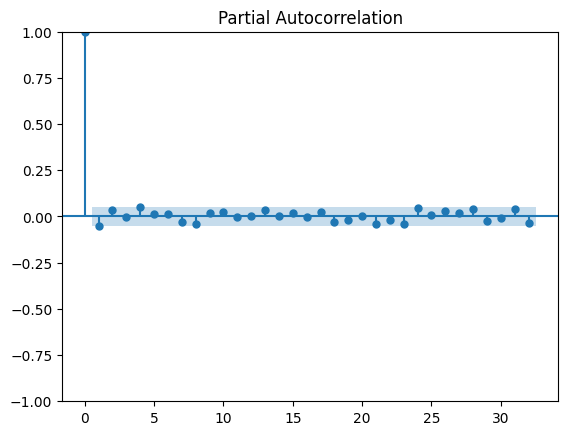

In [25]:
#Tự tương quan riêng phần (PACF - Partitial AutoCorrelation Function):
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax2 = plot_pacf(r_t)

In [32]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(r_t, order = (2, 0, 2))
model_fit = model_arima.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1551
Model:                 ARIMA(2, 0, 2)   Log Likelihood                2897.053
Date:                Tue, 02 May 2023   AIC                          -5782.107
Time:                        09:44:20   BIC                          -5750.027
Sample:                             0   HQIC                         -5770.176
                               - 1551                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.140      0.254      -0.001       0.004
ar.L1          0.2155      0.164      1.313      0.189      -0.106       0.537
ar.L2          0.6676      0.179      3.727      0.0

In [33]:
from statsmodels.tsa.arima.model import ARIMA


def _arima_fit(orders, data):
  models = dict()
  for order in orders:
    model = ARIMA(data, order = order).fit()
    model_name = 'ARIMA({},{},{})'.format(order[0], order[1], order[2])
    print('{} --> AIC={}; BIC={}'.format(model_name, model.aic, model.bic))
    models[model_name] = model
  return models

orders = [(2, 0, 2), (2, 0, 0), (5, 0, 0), (0, 0, 5)]
models = _arima_fit(orders, r_t)

ARIMA(2,0,2) --> AIC=-5782.106533960547; BIC=-5750.0266029814875
ARIMA(2,0,0) --> AIC=-5783.570394351804; BIC=-5762.183773699097
ARIMA(5,0,0) --> AIC=-5782.221787420425; BIC=-5744.79520127819
ARIMA(0,0,5) --> AIC=-5782.4199269166875; BIC=-5744.993340774452


Chọn ARIMA(2,0,0)